## **Network Intrusion Detection with Autoencoder**:


####Detecting anomalies in network traffic is essential for cybersecurity. Traditional detection methods often fail to keep up with evolving cyber threats like unauthorized access, data breaches, and denial-of-service attacks. To address this, we develop a machine learning-based Network Intrusion Detection System (NIDS) using an autoencoder. This approach leverages unsupervised learning to differentiate normal network behavior from potential intrusions, enabling smarter, more adaptable detection of malicious activities.
---

* In this project, we build an autoencoder-based machine learning system to detect network intrusions using the 10% KDD Cup 99 dataset.  
By training the autoencoder to reconstruct normal traffic patterns, we identify anomalies based on reconstruction error and evaluate the system’s performance with precision, recall, and ROC-AUC metrics.


## Importing Required Libraries
This block loads all the necessary Python libraries we’ll use in our project. These tools enable data preprocessing, visualization, model building, and performance evaluation.

🔍 Note:
As we walk through the demonstration, you’ll see how each library contributes to building a complete machine learning pipeline for detecting network intrusions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import seaborn as sns


## Loading the Dataset and Assigning Column Names
We start by defining the **column names** for the dataset. These match the 41 features plus the label used in the KDD Cup 99 dataset — a classic benchmark for network intrusion detection.

In [ ]:
names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

 Then we load the data from a remote `.csv` file hosted on GitHub using `pandas.read_csv()`.
  - `names=names`: assigns the correct column headers to the dataset.
  - `skiprows=1`: skips the original header row in the file (if present), ensuring that our custom column names are applied cleanly.

📌 **Why This Matters:**

Loading the dataset with named columns allows us to:
- Refer to features by name instead of index
- Easily apply preprocessing techniques to specific columns
- Understand and visualize the structure of the dataset during analysis


In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/PacktWorkshops/The-Data-Science-Workshop/master/Chapter09/Dataset/KDDCup99.csv'
data = pd.read_csv(url, names=names, skiprows=1)


Dataset Information:
In this project, we use the 10% subset of the KDD Cup 99 dataset, which contains approximately 494,020 records and 42 features (41 input features + 1 label).
This subset offers a balanced and computationally efficient sample of normal and attack traffic, making it ideal for prototyping and evaluation.



In [ ]:
#A check to  quickly verify that the data loaded correctly and that feature names line up properly.
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


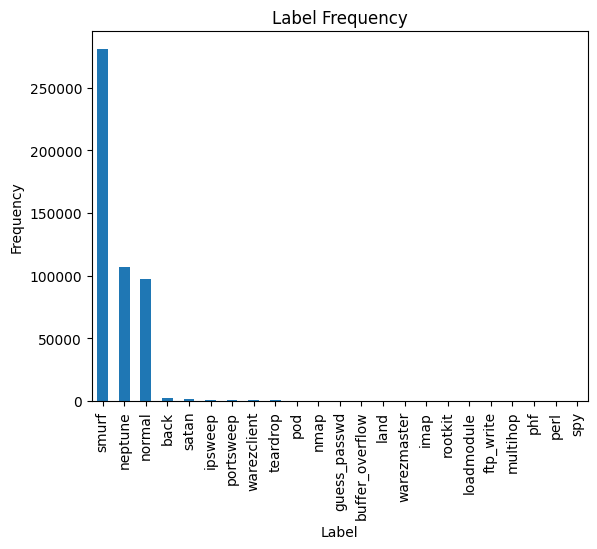

In [ ]:
import matplotlib.pyplot as plt
# Define a function to plot the value counts of each label in the dataset
def plot_value_count(data):
    label_counts = data['label'].value_counts()
    label_counts.plot(kind='bar')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Label Frequency')
    plt.show()

plot_value_count(data)

The bar plot above, shows the frequency distribution of labels in the KDD Cup 1999 dataset. Here’s a detailed explanation of what the plot indicates:


*   Dominant Labels:The labels ‘smurf’ and ‘neptune’ are the most frequent in the dataset, with ‘smurf’ being the most common, followed by ‘neptune’. The ‘normal’ label is also quite frequent, indicating a significant number of normal connections in the dataset.
*   Rare Labels: Several labels, such as ‘pod’, ‘nmap’, ‘phf’, ‘spy’, etc., have very low frequencies, indicating that these types of connections are rare in the dataset.



In [ ]:
# Convert all "normal" labels to a value "0", while all other labels to a value "1". Update the same "label" column in the "data" dataframe with the new value

data['label'] = data['label'].apply(lambda x: 0 if x == 'normal' else 1)


## Splitting the Dataset into Training and Testing Sets


###### 📝 **What This Block Does:**

- **Train/Test Split**:  
  We use `train_test_split()` to divide the dataset:
  - **80%** of the data for training the model (`X_train`, `y_train`)
  - **20%** of the data for evaluating/testing the model (`X_test`, `y_test`)
  - `random_state=55` ensures the split is reproducible (important for consistent results across runs).



In [ ]:
from sklearn.model_selection import train_test_split
#- **Feature and Label Separation**:
#`X` contains all **input features** (everything except the label).
#`y` contains the **binary label** we created (0 = normal, 1 = anomaly).
#We must Separate the labels from the features

X = data.drop("label", axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [ ]:
categorical_features = ["protocol_type", "service", "flag"]

In [ ]:
print("X_train shape before encoding:", X_train.shape)


X_train shape before encoding: (395216, 41)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Combine the train and test datasets before encoding
combined_data = pd.concat([X_train, X_test], axis=0)

# Apply one-hot encoding to categorical columns on combined data
categorical_features = ["protocol_type", "service", "flag"]
# handle_unknown = ignore ensures that if a new category appears during testing, the model won’t crash.
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform on the combined data
combined_data_encoded = encoder.fit_transform(combined_data[categorical_features])

# Create DataFrame with one-hot encoded features
combined_data_encoded_df = pd.DataFrame(combined_data_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_features))

# Re-split the encoded data back into train and test sets
X_train_encoded_df = combined_data_encoded_df.iloc[:len(X_train), :]
X_test_encoded_df = combined_data_encoded_df.iloc[len(X_train):, :]

# Drop the original categorical columns
X_train_dropped = X_train.drop(categorical_features, axis=1)
X_test_dropped  = X_test.drop(categorical_features, axis=1)

# Reset indices so that concatenation lines up rows correctly
X_train_dropped.reset_index(drop=True, inplace=True)
X_train_encoded_df.reset_index(drop=True, inplace=True)

X_test_dropped.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)

# Now concatenate
X_train_final = pd.concat([X_train_dropped,   X_train_encoded_df], axis=1)
X_test_final  = pd.concat([X_test_dropped,    X_test_encoded_df ], axis=1)



In [ ]:
#Note: Three columns were encoded into 80
print(X_train_encoded_df.shape)


(395216, 80)


In [ ]:
#As you can see the number of features increased because of the encoding
print(X_train_final.shape)
print(X_test_final.shape)

(395216, 118)
(98804, 118)


In [ ]:
continuous_features = [x for x in names if x not in categorical_features and x !='label']
print('Total number of non-categorical features: ', len(continuous_features))

# Total number of non-categorical features:  38

Total number of non-categorical features:  38


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reset index in case needed
X_train_final.reset_index(drop=True, inplace=True)
X_test_final.reset_index(drop=True, inplace=True)

# Normalize continuous features in-place
X_train_final[continuous_features] = scaler.fit_transform(X_train_final[continuous_features])
X_test_final[continuous_features] = scaler.transform(X_test_final[continuous_features])

# Display the normalized datasets
print("Normalized X_train:")
print(X_train_final.head())
print("\nNormalized X_test:")
print(X_test_final.head())


Normalized X_train:
   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0  0.000000   0.000001   0.000000   0.0             0.0     0.0  0.0   
1  0.000024   0.000001   0.000064   0.0             0.0     0.0  0.0   
2  0.000000   0.000000   0.000000   0.0             0.0     0.0  0.0   
3  0.000000   0.000001   0.000000   0.0             0.0     0.0  0.0   
4  0.000000   0.000000   0.000000   0.0             0.0     0.0  0.0   

   num_failed_logins  logged_in  num_compromised  ...  flag_REJ  flag_RSTO  \
0                0.0        0.0              0.0  ...       0.0        0.0   
1                0.0        1.0              0.0  ...       0.0        0.0   
2                0.0        0.0              0.0  ...       1.0        0.0   
3                0.0        0.0              0.0  ...       0.0        0.0   
4                0.0        0.0              0.0  ...       0.0        0.0   

   flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
0   

In [ ]:
### test
from sklearn.model_selection import train_test_split

# Step 1: Split the training set again to carve out a validation set
X_train_final, X_val_final, y_train, y_val = train_test_split(
    X_train_final, y_train, test_size=0.1, random_state=42
)


## **What is an Autoencoder?**

An **autoencoder** is a type of neural network designed to **learn a compressed representation** of data, then **reconstruct the original input** from that compressed form.

It consists of two main parts:
- **Encoder**: Reduces (compresses) the input into a smaller latent space representation.
- **Decoder**: Attempts to reconstruct the original input from the compressed encoding.

The network is trained to **minimize the difference** between the original input and its reconstruction — usually using a loss function like **Mean Squared Error (MSE)**.

---

### 📈 Why Autoencoders Are Useful for Anomaly Detection:

- During training, the autoencoder **only learns to reconstruct "normal" data**.
- If the model encounters **anomalous or attack data**, it cannot reconstruct it accurately — leading to **higher reconstruction errors**.
- By setting a threshold on the reconstruction error, we can **flag samples with high errors as anomalies**.

---

 **In short**:  
Autoencoders learn what "normal" looks like — anything that **doesn't fit** leads to a **high reconstruction error**, helping us detect network intrusions!

##  Building the Autoencoder Architecture (Encoder + Decoder)

In [ ]:
# Initialize the input dimension
input_dim = X_train_final.shape[1]  # Number of features

print(input_dim)

118


In [ ]:
# Define the input shape
input_shape = (input_dim,)  # input_dim is the number of dimensions in the training dataset

print(input_shape)

(118,)


In [ ]:
from keras.layers import Input

# Define the input layer
input_layer = Input(shape=input_shape)

print(input_layer)


<KerasTensor shape=(None, 118), dtype=float32, sparse=False, name=keras_tensor>


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

# Encoder
hidden_layer_1 = Dense(128, activation='relu')(input_layer)
hidden_layer_1 = BatchNormalization()(hidden_layer_1)
hidden_layer_1 = Dropout(0.3)(hidden_layer_1)

hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
hidden_layer_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_2 = Dropout(0.3)(hidden_layer_2)

encoded_representation = Dense(8, activation='relu')(hidden_layer_2)




In [ ]:
from tensorflow.keras.models import Model

#  Create the encoder model
encoder = Model(inputs=input_layer, outputs=encoded_representation)

In [ ]:
encoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        15,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,264 (79.16 KB)

 Trainable params: 19,944 (77.91 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
encoded_input = Input(shape=(16,))


In [ ]:
from tensorflow.keras.layers import Dropout

# Decoder part (upsampling)
decoder_input = Input(shape=(8,))  # matches encoded_representation size



hidden_layer_3 = Dense(32, activation='relu')(decoder_input)
hidden_layer_3 = BatchNormalization()(hidden_layer_3)
hidden_layer_3 = Dropout(0.3)(hidden_layer_3)

hidden_layer_4 = Dense(128, activation='relu')(hidden_layer_3)
hidden_layer_4 = BatchNormalization()(hidden_layer_4)
hidden_layer_4 = Dropout(0.3)(hidden_layer_4)

output_layer = Dense(input_dim, activation='sigmoid')(hidden_layer_4)

decoder = Model(inputs=decoder_input, outputs=output_layer)



In [ ]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 118)            │        15,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,374 (79.59 KB)

 Trainable params: 20,054 (78.34 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# Connect encoder and decoder
autoencoder_input = input_layer  # already defined
encoded_output = encoder(autoencoder_input)
reconstructed_output = decoder(encoded_output)

# Full autoencoder model
autoencoder = Model(inputs=autoencoder_input, outputs=reconstructed_output)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
# Reset index to align both X_train_final and y_train
X_train_final.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Now filter training data to only include normal samples (label == 0)
X_train_normal = X_train_final[y_train == 0]

# Check the shape of the filtered data
print(X_train_normal.shape)


(69987, 118)


In [ ]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 8)              │        20,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 118)            │        20,374 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,638 (158.74 KB)

 Trainable params: 39,998 (156.24 KB)

 Non-trainable params: 640 (2.50 KB)

## Training the Autoencoder

After building the full autoencoder model, we compile and train it:

```python
autoencoder.compile(optimizer='adam', loss='mse')

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_normal, X_train_normal,  # Train only on normal traffic
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test_final, X_test_final),
    callbacks=[early_stopping]
)
```

---

### 📝 **What This Block Does:**

- **Compilation**:  
  - The model is compiled with the **Adam optimizer** (adaptive learning rate) and **Mean Squared Error (MSE)** as the loss function.
  - MSE measures how well the autoencoder reconstructs the input.

- **Training**:  
  - We train the model **only on normal samples** so that it specializes in learning typical traffic patterns.
  - `X_train_normal` is the training input and target output (because autoencoders aim to reconstruct their input).
  - **EarlyStopping** monitors the validation loss and stops training if it doesn't improve for 5 consecutive epochs, preventing overfitting.

- **Validation**:
  - During training, we validate against the full test set (both normal and anomalous) to monitor generalization.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
history = autoencoder.fit(
    X_train_normal, X_train_normal,  # train only on normal traffic
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test_final, X_test_final),
    callbacks=[early_stopping]
)


Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.1623 - val_loss: 0.0956
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0565 - val_loss: 0.0471
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0244 - val_loss: 0.0455
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0076 - val_loss: 0.0440
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0066 - val_loss: 0.0441
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0062 - val_loss: 0.0434
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0059 - val_loss: 0.0432
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0057 - val_loss: 0.0424
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0056 - val_loss: 0.0412
Epoch 10/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0054 - val_loss: 0.0401
Epoch 11/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0052 - val_loss: 0.0385
Epoch 12/50
274/274 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# rename your autoencoder’s encoder so it doesn’t clobber the sklearn one
encoder_model = encoder
# (or change the model‐building line to `encoder_model = Model(…)` above)
# now use it on the fully preprocessed data:
encoded_train_features = encoder_model.predict(X_train_final)
encoded_test_features  = encoder_model.predict(X_test_final)

print(encoded_train_features.shape)
print(encoded_test_features.shape)


11116/11116 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
(355694, 8)
(98804, 8)


In [ ]:
encoded_train_features.shape

(355694, 8)

In [ ]:
#First, we use the trained autoencoder to reconstruct both the training and testing data:
X_train_recon = autoencoder.predict(X_train_final)
X_test_recon  = autoencoder.predict(X_test_final)


11116/11116 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
#Then, calculate the reconstruction error:
import numpy as np
reconstructed_train = autoencoder.predict(X_train_normal)
reconstructed_test = autoencoder.predict(X_test_final)

mse_train = np.mean(np.power(X_train_normal - reconstructed_train, 2), axis=1)
mse_test = np.mean(np.power(X_test_final - reconstructed_test, 2), axis=1)


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
import numpy as np
import pandas as pd

mse_train_arr = np.mean((X_train_final - X_train_recon)**2, axis=1)
mse_test_arr  = np.mean((X_test_final  - X_test_recon )**2, axis=1)

# Turn into Series with the same indices as your DataFrames
mse_train = pd.Series(mse_train_arr, index=X_train_final.index)
mse_test  = pd.Series(mse_test_arr,  index=X_test_final.index)


In [ ]:
# Get reconstruction error on validation set
X_val_recon = autoencoder.predict(X_val_final)
mse_val = np.mean((X_val_final - X_val_recon)**2, axis=1)

# Find best threshold using validation set
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, mse_val)
f1_scores = 2*recall*precision / (recall + precision + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1 score (from validation set):", best_threshold)


1236/1236 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Best threshold for F1 score (from validation set): 0.016549797645104034


In [ ]:
threshold = best_threshold


In [ ]:
y_pred = (mse_test > best_threshold).astype(int)


## Finally, **make predictions** and **evaluate performance**:


### 📝 **What This Block Does:**

- **Thresholding**:  
  We select a threshold based on the best F1 score to classify whether a sample is anomalous or normal based on its reconstruction error.

- **Evaluation**:  
  We report:
  - **Precision, Recall, F1-Score** (from the classification report)
  - **Confusion Matrix** (to see normal vs attack prediction counts)
  - **ROC AUC Score** (how well the model separates normal vs anomaly)
  - **Overall Accuracy**

- **Visualization**:
  We use a **heatmap** to make the confusion matrix easy to interpret.

---

✅ After this, you have full training, detection, and evaluation completed!

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['normal','anomaly']))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC (using MSE as score):", roc_auc_score(y_test, mse_test))
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)




Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.99      0.98     19449
     anomaly       1.00      0.99      0.99     79355

    accuracy                           0.99     98804
   macro avg       0.98      0.99      0.99     98804
weighted avg       0.99      0.99      0.99     98804

Confusion Matrix:
 [[19246   203]
 [  644 78711]]
ROC AUC (using MSE as score): 0.9964325782192479
Accuracy: 0.9914274725719606


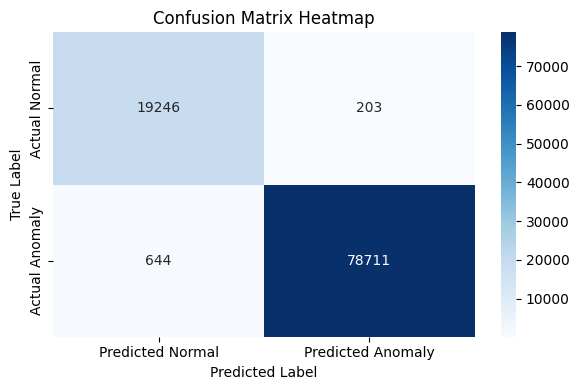

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create and plot the heatmap
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()


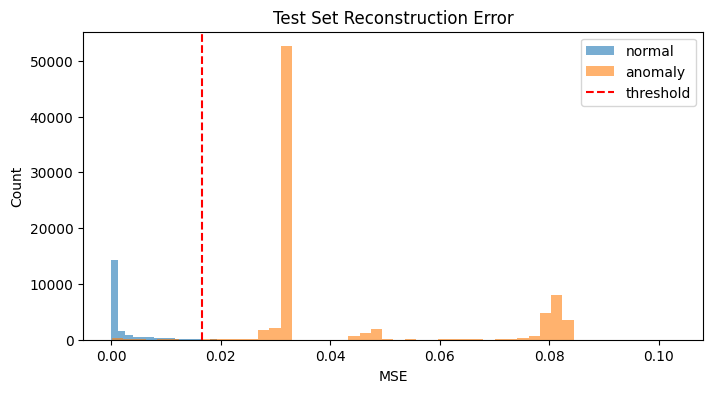

In [ ]:
# First convert to NumPy arrays, aligning y_test with mse_test
y_test_arr   = y_test.reset_index(drop=True).values    # now 0…N-1
mse_test_arr = mse_test.values                         # same length

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(mse_test_arr[y_test_arr==0], bins=50, alpha=0.6, label='normal')
plt.hist(mse_test_arr[y_test_arr==1], bins=50, alpha=0.6, label='anomaly')
plt.axvline(threshold, color='r', linestyle='--', label='threshold')
plt.title("Test Set Reconstruction Error")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.show()


#Project Conclusion

In this project, we successfully developed an **autoencoder-based Network Intrusion Detection System (NIDS)** using the 10% subset of the **KDD Cup 99 dataset**.

We walked through the entire pipeline:
- **Loading and preprocessing** real-world network traffic data,
- **Encoding categorical features** and **scaling continuous features** for model readiness,
- **Building a deep autoencoder** to learn compressed representations of normal network behavior,
- **Training** the model exclusively on normal traffic to specialize in reconstruction of legitimate patterns,
- **Using reconstruction error** to **detect anomalies** in unseen data,
- **Evaluating model performance** using precision, recall, F1-score, ROC-AUC, and confusion matrix visualization.

### 📈 Final Results Highlights:
- Achieved **high classification accuracy** and a **strong ROC-AUC score**, demonstrating that the autoencoder could effectively differentiate between normal and malicious network activity.
- Identified the **optimal threshold** based on F1-score to balance between false positives and false negatives.

---

# 🎯 **Key Takeaways**

- **Autoencoders are powerful tools** for anomaly detection in situations where labeled anomaly data is scarce.
- Proper **data preprocessing** — especially **encoding** and **normalization** — is critical for building effective neural networks.
- **Reconstruction error** is a reliable signal for detecting deviations from normal patterns.

---

# 📚 **Future Improvements**

- Explore **deeper or more complex autoencoder architectures** (e.g., convolutional or variational autoencoders).
- Fine-tune **hyperparameters** such as the number of hidden units, batch size, and learning rate.
- Test the system on other datasets (e.g., NSL-KDD, UNSW-NB15) to validate its generalization ability.
